#### Contest entry - Wouter Kimman 

submission2


--------------------------------------------------------------------------------------------
minor changes:

-preprocessing well by well 

-added the prediction (n) and (n-1) as a new feature

--------------------------------------------------------------------------------------------

In [2]:
from numpy.fft import rfft
from scipy import signal

import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py


import pandas as pd
import timeit
from sqlalchemy.sql import text
from sklearn import tree
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#import sherlock.filesystem as sfs
#import sherlock.database as sdb

from sklearn import preprocessing

from sklearn.cross_validation import train_test_split

First steps, reading in and exploring the data are the same as Brendon's steps:

Train for the test data
---------------------------------------------------

In [26]:
# ALL preprocessing in 1 go
filename = 'training_data.csv'
training_data0 = pd.read_csv(filename)
df=training_data0.copy()
training_data1=magic1(df)

filename = 'validation_data_nofacies.csv'
test_data = pd.read_csv(filename)

In [1635]:
training_data0['Well Name'] = training_data0['Well Name'].astype('category')
training_data0['Formation'] = training_data0['Formation'].astype('category')
training_data0['Well Name'].unique()

[SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (8, object): [SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

In [31]:

def predict_final(test_well, training_data,test_data):
    blind = test_data[test_data['Well Name'] == test_well]      
    correct_facies_labels_train = training_data['Facies'].values
    #feature_vectors_train = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
    feature_vectors_train = training_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)    
    rf = RandomForestClassifier(max_depth = 15, n_estimators=600) 
    rf.fit(feature_vectors_train, correct_facies_labels_train)

    # the blind well
    feature_vectors_blind = blind.drop(['Formation', 'Well Name', 'Depth'], axis=1)
    predicted_random_forest = rf.predict(feature_vectors_blind)
    #out_f1=metrics.f1_score(correct_facies_labels, predicted_random_forest,average = 'micro')
    return predicted_random_forest

        

In [1666]:
test_well='STUART'
predicted_stu=predict_final(test_well, training_data1, test_data1)
test_well='CRAWFORD'
predicted_craw=predict_final(test_well, training_data1, test_data1)


-------------------------------------------------------------------------------------
NEW


In [22]:
temp1=training_data0.groupby('Well Name')
temp2=test_data0.groupby('Well Name')
#temp1.describe()
temp1.mean()


,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Well Name,,,,,,,,,
CHURCHMAN BIBLE,5.655941,3019.482673,63.683453,0.758757,1.560000,14.011116,3.789926,1.722772,0.544317
CROSS H CATTLE,3.127745,2702.360279,72.699285,0.568829,2.466667,15.574850,3.325852,1.297405,0.506182
LUKE G U,4.353579,2725.708243,64.777223,0.639690,4.218438,12.953905,3.660705,1.466377,0.514095
NEWBY,4.801296,2941.500000,60.733045,0.674812,3.477970,11.625378,3.771706,1.615551,0.528138
NOLAN,4.643373,2957.000000,68.693940,0.592400,3.134070,12.197361,3.857947,1.527711,0.549007
Recruit F9,9.000000,3038.367647,44.712853,0.567853,1.436515,13.183368,5.460735,2.000000,0.448279
SHANKLE,3.576837,2890.502227,65.431180,0.630831,2.348998,15.741125,3.224944,1.340757,0.503118
SHRIMPLIN,4.384289,2910.501062,69.408896,0.659679,7.708493,12.173705,4.219958,1.488323,0.514482


In [5]:
def magic1(df):
    df1=df.copy()
    b, a = signal.butter(2, 0.2, btype='high', analog=False)
    feats00=['GR','ILD_log10','DeltaPHI','PHIND','PE','NM_M','RELPOS']
    feats01=['GR','DeltaPHI','PHIND']
    for ii in feats00:
        df1[ii]=df[ii]
        name1=ii + '_1'
        name2=ii + '_2'
        name3=ii + '_3'
        name4=ii + '_4'
        xx1 = list(df[ii])
        xx_mf= signal.medfilt(xx1,9)
        x_min3=np.roll(xx_mf, 3)    
        xx1a=xx1-np.mean(xx1)
        xx_fil = signal.filtfilt(b, a, xx1)
        xx_grad=np.gradient(xx1a) 
        if ii in feats01: 
            df1[name1]=x_min3
            df1[name2]=xx_fil
            df1[name3]=xx_grad
            df1[name4]=xx_mf     
    return df1


In [6]:

def run_test1(remove_well, df_train, df_test):
    blind = df_test[df_test['Well Name'] == remove_well]      
    training_data = df_train[df_train['Well Name'] != remove_well]  

    correct_facies_labels_train = training_data['Facies'].values
    feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
    scaler = preprocessing.StandardScaler().fit(feature_vectors)
    #scaled_features_train = scaler.transform(feature_vectors)
    scaled_features_train = feature_vectors
    
    rf = RandomForestClassifier(max_depth = 15, n_estimators=600) 
    rf.fit(scaled_features_train, correct_facies_labels_train)


    # get the blind well
    correct_facies_labels = blind['Facies'].values
    feature_vectors = blind.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
    scaler = preprocessing.StandardScaler().fit(feature_vectors)
    #scaled_features = scaler.transform(feature_vectors)
    scaled_features =feature_vectors

    predicted_random_forest = rf.predict(scaled_features)

    out_f1=metrics.f1_score(correct_facies_labels, predicted_random_forest,average = 'micro')
    return out_f1, predicted_random_forest

    

run preprocessing well by well
(more correct in terms of filtering)

In [481]:
df=training_data0.copy()
wells=['CHURCHMAN BIBLE','SHANKLE','NOLAN','NEWBY','Recruit F9' ,'CROSS H CATTLE','LUKE G U','SHRIMPLIN']

appended_data=[]
for name in wells:
    dff=df[df['Well Name']==name]
    dfnew1=magic1(dff)    
    appended_data.append(dfnew1)
    
appended_data1 = pd.concat(appended_data, axis=0)
appended_data1.head()  
training_data3=appended_data1.copy()

How well do we do beforehand:

In [484]:
training_data1.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,...,GR_3,GR_4,DeltaPHI_1,DeltaPHI_2,DeltaPHI_3,DeltaPHI_4,PHIND_1,PHIND_2,PHIND_3,PHIND_4
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,...,0.810,74.58,1.828,-0.001270,4.30,9.9,7.254,-0.006415,0.6500,11.915
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,...,0.800,74.58,1.828,2.592465,2.45,13.5,7.149,0.188713,0.5675,12.565
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,...,3.920,74.58,1.828,1.802692,-0.15,13.9,6.668,0.263665,0.2750,13.050
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,...,-2.235,75.65,9.900,-0.068553,-0.65,14.0,11.915,-0.010605,0.1250,13.115
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,...,-6.065,75.65,13.500,-1.139593,0.05,14.2,12.565,-0.092611,0.1350,13.300


In [7]:

def add_previous_facies(df):
    N=len(df)
    dfnew=df.copy()
    dfnew.iloc[0]=df.iloc[0]
    facies_old=df.iloc[0]
    for ii in range(1,N):
        facies_try1=df.iloc[ii-1]           # the previous value of the facies 
        facies_try2=df.iloc[ii]             # the current value of the facies   
        if facies_try1==facies_try2:
            dfnew.iloc[ii]=facies_old 
        elif facies_try1!=facies_try2: 
            facies_old=facies_try1                                      # and set the previous value to this nr
            dfnew.iloc[ii]=facies_old                                  # then set to the previous facies
    return dfnew     
            
    
def add_next_facies(df):
    N=len(df)
    dfnew=df.copy()
    dfnew.iloc[N-1]=df.iloc[N-1]
    facies_old=df.iloc[N-1]
    for ii in range(N-2,-1,-1):
        #print ii
        facies_try1=df.iloc[ii+1]           # the previous value of the facies 
        facies_try2=df.iloc[ii]             # the current value of the facies   
        if facies_try1==facies_try2:
            dfnew.iloc[ii]=facies_old 
        elif facies_try1!=facies_try2: 
            facies_old=facies_try1                                      # and set the previous value to this nr
            dfnew.iloc[ii]=facies_old                                  # then set to the previous facies
    return dfnew  
    

In [70]:
def add_prediction(training_data1, predicted_random_forest, remove_well):
    
    df_test=training_data1
    df_train=training_data1
    
    blind = df_test[df_test['Well Name'] == remove_well]      
    df_train_noblind = df_train[df_train['Well Name'] != remove_well]  


    blind['facies_pred'] = pd.Series(predicted_random_forest, index=blind.index)

#   df=blind['facies_pred']
#   mask = blind['Well Name']==remove_well 
#   blind.loc[mask, 'facies_pred'] = df 
 
    return blind, df_train_noblind

In [8]:
def add_previous(training_data1, predicted_random_forest, remove_well):
    
    df_test=training_data1
    df_train=training_data1
    
    blind = df_test[df_test['Well Name'] == remove_well]      
    df_train_noblind = df_train[df_train['Well Name'] != remove_well]  

    blind['facies_pred'] = pd.Series(predicted_random_forest, index=blind.index)
    df=blind['facies_pred']
    dfnew1=add_previous_facies(df)  
    mask = blind['Well Name']==remove_well
    blind.loc[mask, 'facies_min1'] = dfnew1 
    
    return blind, df_train_noblind
    

In [110]:
def addn_1(wells, blindwell, blind, df_train_noblind):

    blind1=blind.copy()
    blind1['facies_min1']=0.0*blind1['facies_pred']

    # calculating n-1 using for n the predicted facies of the blind well
    #df=blind1['Facies'][blind1['Well Name']==blindwell]
    df=blind1['facies_pred'][blind1['Well Name']==blindwell]    
    dfnew1=add_previous_facies(df)  
    mask = blind1['Well Name']==blindwell
    blind1.loc[mask, 'facies_min1'] = dfnew1   

    #=========
    # calculating n-1 using for n the true facies of the training wells
    df_train_noblind1=df_train_noblind.copy()
    df_train_noblind1['facies_min1']=0.0*df_train_noblind1['Facies']

    for name in wells:
        df=df_train_noblind1['Facies'][df_train_noblind1['Well Name']==name]
        dfnew1=add_previous_facies(df)      
        mask = df_train_noblind1['Well Name']==name
        df_train_noblind1.loc[mask, 'facies_min1'] = dfnew1
        
    return blind1, df_train_noblind1


In [157]:
def add_surrounding0(predicted_random_forest, remove_well, blind, df_train_noblind):
    
    #df_test=training_data1
    #df_train=training_data1
    
    #blind = df_test[df_test['Well Name'] == remove_well]      
    #df_train_noblind = df_train[df_train['Well Name'] != remove_well]  


    blind['facies_pred'] = pd.Series(predicted_random_forest, index=blind.index)

    df=blind['facies_pred']
    dfnew1=add_previous_facies(df)  
    dfnew2=add_previous_facies(dfnew1)
    dfnew3=add_next_facies(df) 
    dfnew4=add_next_facies(dfnew3)
    appended_data=[]
    appended_data.append(df) 
    appended_data.append(df)     
    appended_data.append(dfnew1)   
    appended_data.append(dfnew2)    
    AA1 = pd.concat(appended_data, axis=1)
    most_common=AA1.median(axis=1)

    mask = blind['Well Name']==remove_well
    #blind.loc[mask, 'facies_min1'] = most_common 
    blind.loc[mask, 'facies_pred'] = most_common 
    #blind['facies_min1'][blind['Well Name']==remove_well]=dfnew1
 
    return blind, df_train_noblind

In [158]:
def add_surrounding(predicted_random_forest, remove_well, blind, df_train_noblind):
    
    #df_test=training_data1
    #df_train=training_data1
    
    #blind = df_test[df_test['Well Name'] == remove_well]      
    #df_train_noblind = df_train[df_train['Well Name'] != remove_well]  


    blind['facies_pred'] = pd.Series(predicted_random_forest, index=blind.index)

    df=blind['facies_pred']
    dfnew1=add_previous_facies(df)  
    dfnew2=add_previous_facies(dfnew1)
    dfnew3=add_next_facies(df) 
    dfnew4=add_next_facies(dfnew3)
    appended_data=[]
    appended_data.append(df) 
    appended_data.append(df)     
    appended_data.append(df) 
    appended_data.append(dfnew1)
    appended_data.append(dfnew1)
    appended_data.append(dfnew2)
    appended_data.append(dfnew3)
    appended_data.append(dfnew4)
    AA1 = pd.concat(appended_data, axis=1)
    most_common=AA1.median(axis=1)

    mask = blind['Well Name']==remove_well
    #blind.loc[mask, 'facies_min1'] = most_common 
    blind.loc[mask, 'facies_pred'] = most_common 
    #blind['facies_min1'][blind['Well Name']==remove_well]=dfnew1
 
    return blind, df_train_noblind

In [204]:
def make_predict(df_train_noblind, blind):
    correct_facies_labels_train = df_train_noblind['Facies'].values
    scaled_features_train = df_train_noblind.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
    
    rf = RandomForestClassifier(max_depth = 15, n_estimators=600) 
    rf.fit(scaled_features_train, correct_facies_labels_train)

    # get the blind well
    correct_facies_labels = blind['Facies'].values
    feature_vectors = blind.drop(['Formation', 'Well Name', 'Depth','Facies','facies_pred'], axis=1)
    #scaler = preprocessing.StandardScaler().fit(feature_vectors)

    predicted_random_forest = rf.predict(feature_vectors)
    out_f1=metrics.f1_score(correct_facies_labels, predicted_random_forest,average = 'micro')
    print out_f1
    return out_f1, predicted_random_forest


In [207]:
def make_predict_test(df_train_noblind, blind):
    correct_facies_labels_train = df_train_noblind['Facies'].values
    scaled_features_train = df_train_noblind.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
    
    rf = RandomForestClassifier(max_depth = 15, n_estimators=600) 
    rf.fit(scaled_features_train, correct_facies_labels_train)
    
    feature_vectors = blind.drop(['Formation', 'Well Name', 'Depth','facies_pred'], axis=1)
    
    predicted_random_forest = rf.predict(feature_vectors)
    return predicted_random_forest


------------------------------------
START 
------------------------------------

In [168]:
# ALL preprocessing in 1 go
filename = 'training_data.csv'
training_data0 = pd.read_csv(filename)
df=training_data0.copy()

#first preprocessing:
training_data1=magic1(df)




In [169]:
df=training_data0.copy()
wells=['CHURCHMAN BIBLE','SHANKLE','NOLAN','NEWBY','Recruit F9' ,'CROSS H CATTLE','LUKE G U','SHRIMPLIN']

appended_data=[]
for name in wells:
    dff=df[df['Well Name']==name]
    dfnew1=magic1(dff)    
    appended_data.append(dfnew1)
    
appended_data1 = pd.concat(appended_data, axis=0)
appended_data1.head()  
training_data2=appended_data1.copy()




First prediction:

In [183]:

#df_train=training_data1
#df_test=training_data1

df_train=training_data2
df_test=training_data2

wells=['CHURCHMAN BIBLE']
#wells=['SHANKLE']
av_all=[]
for remove_well in wells:
    all=[]
    print("well : %s, f1 for different runs:" % (remove_well))
    for ii in range(25):
        out_f1, predicted_random_forest=run_test1(remove_well,df_train, df_test)
        print out_f1
        all.append(out_f1)
    av1=np.mean(all) 
    av_all.append(av1)
    print("average f1 is %f, 2*std is %f" % (av1, 2*np.std(all)) )

print("overall average f1 is %f" % (np.mean(av_all)))

well : CHURCHMAN BIBLE, f1 for different runs:
0.571782178218
0.569306930693
0.584158415842
0.574257425743
0.564356435644
0.581683168317
0.566831683168
0.576732673267
0.574257425743
0.571782178218
0.576732673267
0.581683168317
0.579207920792
0.586633663366
0.586633663366
0.584158415842
0.584158415842
0.579207920792
0.581683168317
0.569306930693
0.589108910891
0.576732673267
0.574257425743
0.576732673267
0.579207920792
average f1 is 0.577624, 2*std is 0.012747
overall average f1 is 0.577624


ADDING PREDICTION INFORMATION AND SEPERATE INTO BLIND AND REST

In [184]:
remove_well='CHURCHMAN BIBLE'
#remove_well='SHANKLE'
#blind, df_train_noblind = add_previous(training_data1, predicted_random_forest, remove_well)
blind, df_train_noblind = add_prediction(training_data2, predicted_random_forest, remove_well)

/home/sherlock/anaconda/envs/Python2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



ADDING N-1 INFORMATION

In [185]:
#blindwell='SHANKLE'
#wells=['CHURCHMAN BIBLE','NOLAN','NEWBY','Recruit F9' ,'CROSS H CATTLE','LUKE G U','SHRIMPLIN']
blindwell='CHURCHMAN BIBLE'
wells=['SHANKLE','NOLAN','NEWBY','Recruit F9' ,'CROSS H CATTLE','LUKE G U','SHRIMPLIN']
blind1, df_train_noblind1=addn_1(wells, blindwell, blind, df_train_noblind)

Make first prediction using pred and n-1

In [186]:
out_f1, predicted_random_forest1= make_predict(df_train_noblind1, blind1)


blind2, df_train_noblind2 = add_surrounding(predicted_random_forest, remove_well, blind1, df_train_noblind1)
out_f1, predicted_random_forest2= make_predict(df_train_noblind2, blind2)


0.576732673267
0.564356435644


The 2 steps above can be done recursively. (but does f1 still improve?)

In [222]:
blind=blind1
df_train_noblind=df_train_noblind1
predicted_random_forest=predicted_random_forest1
all1=[]
for ii in range(10):
    print "iteration " + str(ii+1)
    blind['facies_pred'] = pd.Series(predicted_random_forest, index=blind.index)
    #blind, df_train_noblind=addn_1(wells, blindwell, blind, df_train_noblind)
    #blind, df_train_noblind = add_surrounding(predicted_random_forest, remove_well, blind, df_train_noblind)    
    out_f1, predicted_random_forest= make_predict(df_train_noblind, blind)
    all1.append(out_f1)

print("overall average f1 is %f" % (np.mean(all1)))    

iteration 1


ValueError: Wrong number of items passed 404, placement implies 356

In [98]:
#predicted_random_forest_first=predicted_random_forest
#for ii in range(4):
#    blind, df_train_noblind = add_surrounding2(training_data2, predicted_random_forest, remove_well)   
#    out_f1, predicted_random_forest= make_predict(df_train_noblind, blind)

In [38]:
#fig, ax = plt.subplots(figsize=(30, 20))
#plt.plot(correct_facies_labels, color='black', label='facies')
#plt.plot(predicted_random_forest, color='red', label='predicted')
#plt.show()

FINAL PREDICTIONS
------------------

In [192]:
filename = 'validation_data_nofacies.csv'
test_data = pd.read_csv(filename)
df=test_data.copy()

#test_data1=magic1(df)


In [193]:
df=test_data.copy()
wells=['STUART','CRAWFORD']
appended_data=[]
for name in wells:
    dff=df[df['Well Name']==name]
    dfnew1=magic1(dff)    
    appended_data.append(dfnew1)
    
appended_data1 = pd.concat(appended_data, axis=0)
appended_data1.head()  
test_data2=appended_data1.copy()

In [194]:
test_well='STUART'
predicted_stu=predict_final(test_well, training_data1, test_data2)

test_well='CRAWFORD'
predicted_craw=predict_final(test_well, training_data1, test_data2)


In [196]:
test_well='STUART'
mask = test_data2['Well Name']==test_well
test_data2.loc[mask, 'facies_pred'] = predicted_stu

test_well='CRAWFORD'
mask = test_data2['Well Name']==test_well
test_data2.loc[mask, 'facies_pred'] = predicted_craw


In [197]:
test_data2.head()

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,...,GR_4,DeltaPHI_1,DeltaPHI_2,DeltaPHI_3,DeltaPHI_4,PHIND_1,PHIND_2,PHIND_3,PHIND_4,facies_pred
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000,...,66.276,4.9,0.007292,3.20,3.3,15.40,0.002097,1.300,10.65,2.0
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978,...,73.955,4.4,1.103575,3.05,6.5,15.25,0.412649,1.475,11.95,2.0
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956,...,75.971,3.5,2.345797,1.50,6.5,15.20,1.354095,0.650,12.25,3.0
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933,...,77.252,3.3,1.501496,-0.35,6.5,10.65,0.574618,-0.625,12.35,2.0
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911,...,77.962,6.5,0.459993,-1.30,6.7,11.95,-0.506543,-0.500,12.45,2.0


In [217]:
test_well='STUART'
wells=['CHURCHMAN BIBLE','SHANKLE','NOLAN','NEWBY','Recruit F9' ,'CROSS H CATTLE','LUKE G U','SHRIMPLIN']

df_test=test_data2[test_data2['Well Name']==test_well]

blind1, df_train_noblind1=addn_1(wells, test_well, df_test, training_data2)

FINAL PREDICTION

In [218]:
predicted_stu1= make_predict_test(df_train_noblind1, blind1)
predicted_stu1


array([3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 8, 8, 8,
       8, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 6, 8, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 8, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 5, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 2, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 2, 3, 1,
       3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 8, 8, 8, 8,
       8, 8,

In [219]:
test_well='CRAWFORD'
wells=['CHURCHMAN BIBLE','SHANKLE','NOLAN','NEWBY','Recruit F9' ,'CROSS H CATTLE','LUKE G U','SHRIMPLIN']

df_test=test_data2[test_data2['Well Name']==test_well]

blind1, df_train_noblind1=addn_1(wells, test_well, df_test, training_data2)

In [220]:
predicted_craw1= make_predict_test(df_train_noblind1, blind1)
predicted_craw1

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 4, 7, 7, 7, 7, 4, 4, 4, 4,
       4, 7, 4, 4, 4, 4, 4, 6, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6,
       8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       4, 4, 4, 8, 8, 8, 8, 8, 5, 3, 3, 3, 3, 3, 3, 7, 5, 5, 8, 8, 8, 8, 6,
       6, 6, 6, 6, 6, 6, 8, 8, 8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 6, 6, 5, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8,
       8, 8, 8, 8, 6, 6, 6, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 3, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 7,
       7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 3, 2, 2, 1, 1, 1, 2, 2, 2, 2,
       3, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7,

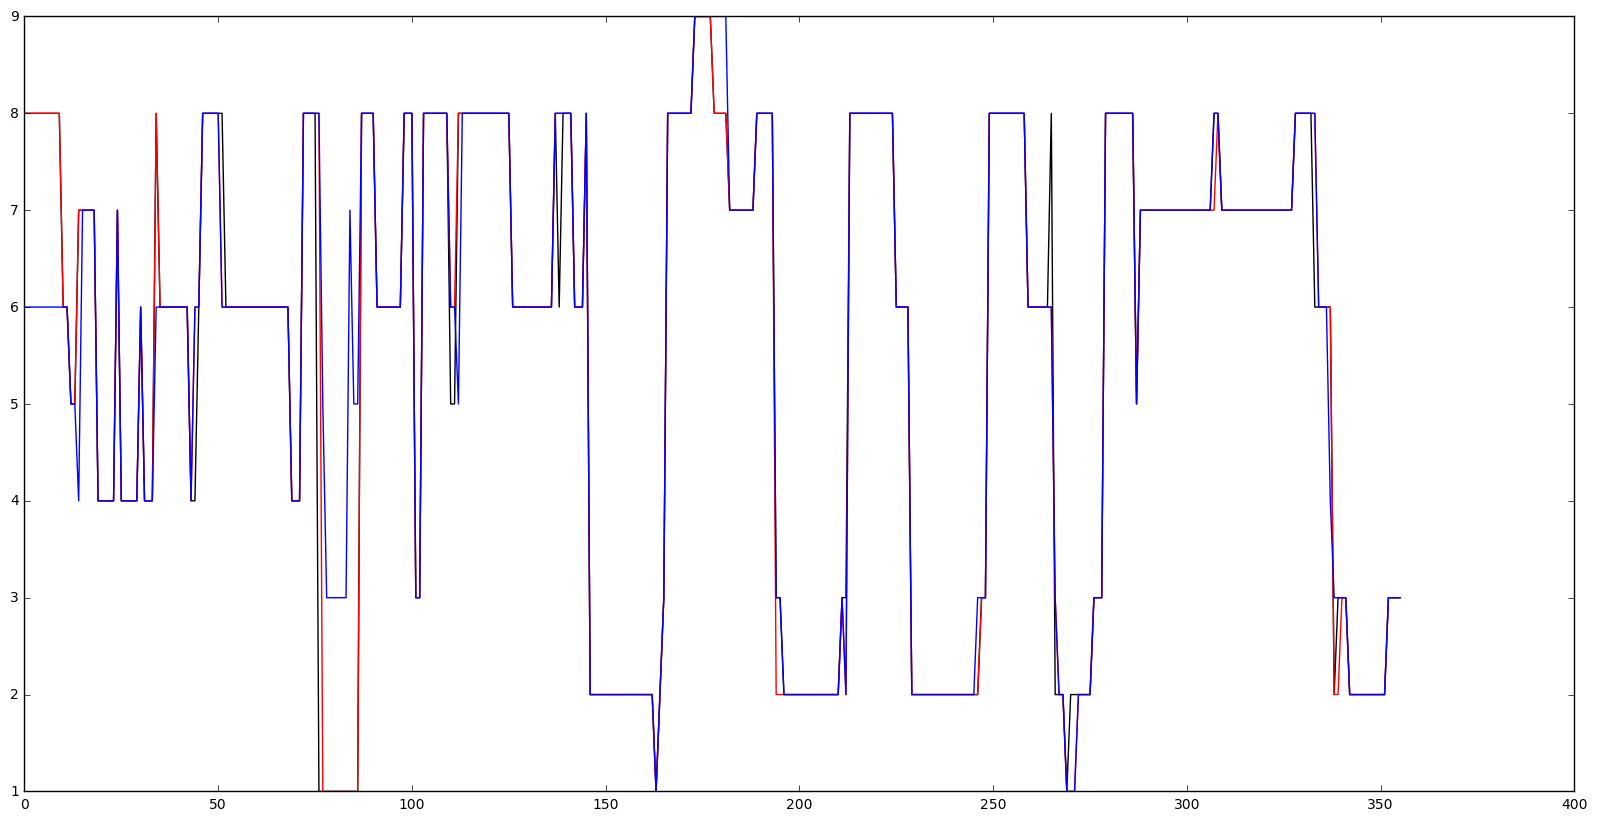

In [223]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(predicted_craw0, color='black', label='facies')
plt.plot(predicted_craw, color='red', label='predicted')
plt.plot(predicted_craw1, color='blue', label='predicted')
plt.show()